# Modeling Phase

## Introduction

This notebook outlines the modeling phase, utilizing preprocessed data and pipelines from `AlternativePreprocessing.ipynb`. All feature engineering and label engineering, including the generation of `RISK_LEVEL` via Spatio-Temporal Kernel Density Estimation (STKDE), are conducted in a manner that prevents data leakage. This is achieved by performing these operations, including the determination of STKDE intensity thresholds using Jenks natural breaks, only after the initial train/test split and subsequently within each cross-validation fold. The classification task is to distinguish between two risk categories: "LOW RISK" and "HIGH RISK".

**Dependencies:**
- Artifacts from `Classification (Preprocessing)` (including data, pipelines, STKDE parameters, and the `scoring_dict`).
- Custom transformers and modular pipelines defined in `custom_transformers.py`.

**Objectives:**
- Select the optimal model for 2-class risk classification through rigorous cross-validation.
- Perform hyperparameter tuning for the selected model.
- Evaluate the model\'s generalization performance on the unseen test set.

# Setup

This section handles the initial setup, including importing necessary libraries, defining file paths, and loading the preprocessed data. All custom functions are imported from `custom_transformers.py` to maintain modularity and facilitate code reuse for the 2-class risk classification.

## Optional: Run on Google Colab

This cell is for users working in a Google Colab environment. If you are running this notebook locally, you can safely ignore this section.

In [1]:
# Run on Google Colab (optional)
# from google.colab import drive
# drive.mount('/drive', force_remount=True)

## Import Libraries

Import all libraries required for the modeling process and for generating visualizations. Custom functions, critical for specific transformations and operations for the 2-class problem, are imported from the `custom_transformers.py` script.

In [2]:
import os
import sys
import json
import random
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List

from sklearn.model_selection import (
    StratifiedKFold, cross_validate, RandomizedSearchCV, TimeSeriesSplit
)
from sklearn.metrics import (
    log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, 
    recall_score, matthews_corrcoef, make_scorer, average_precision_score
)
from sklearn.base import clone

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import (
    EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
)

from Utilities.custom_transformers import STKDEAndRiskLabelTransformer, CustomModelPipeline, cyclical_transform
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, 
    BaggingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set seeds and styles
random.seed(42)
np.random.seed(42)
sns.set_style('whitegrid')
# Warnings filter
warnings.filterwarnings('ignore')

## Define Paths

Establish and define the directory paths for loading preprocessed data and for saving the results of the modeling phase, such as trained models, performance metrics, and generated plots for the 2-class problem.

In [3]:
base_dir = r"C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs"

preprocessing_dir = os.path.join(base_dir, "Classification (Preprocessing)")
modeling_results_dir = os.path.join(base_dir, "Classification (Modeling)")
os.makedirs(modeling_results_dir, exist_ok=True)
print(f"Preprocessing artifacts will be loaded from: {preprocessing_dir}")
print(f"Modeling results will be saved to: {modeling_results_dir}")

Preprocessing artifacts will be loaded from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Preprocessing)
Modeling results will be saved to: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)


## Load Data and Pipelines

Load the unprocessed data splits (`X_train`, `y_train`, `X_test`, `y_test`), the unfitted preprocessing pipelines, the list of feature names, and the scoring dictionary. These artifacts were previously generated and saved by the `AlternativePreprocessing.ipynb` notebook.

In [4]:
print("=== Loading data and pipelines ===")

def load_preprocessing_artifacts(preprocessing_dir: str) -> Dict[str, Any]:
    """Load preprocessing artifacts with comprehensive error handling.
    """
    print("=== Loading Preprocessing Artifacts ===")
    if not os.path.exists(preprocessing_dir):
        raise FileNotFoundError(f"Preprocessing directory not found: {preprocessing_dir}")
    try:
        # Load data arrays
        X_train = pd.read_pickle(os.path.join(preprocessing_dir, 'X_train.pkl'))
        X_test = pd.read_pickle(os.path.join(preprocessing_dir, 'X_test.pkl'))
        y_train = pd.read_pickle(os.path.join(preprocessing_dir, 'y_train.pkl'))
        y_test = pd.read_pickle(os.path.join(preprocessing_dir, 'y_test.pkl'))
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Required data files missing: {e}")
    except Exception as e:
        raise RuntimeError(f"Error loading data files: {e}")

    # Load preprocessors if available
    preprocessor_general_ct = None
    preprocessor_trees_ct = None
    
    general_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_general.joblib')
    trees_path = os.path.join(preprocessing_dir, 'preprocessing_pipeline_trees.joblib')
    
    if os.path.exists(general_path):
        try:
            pipeline_general = joblib.load(general_path)
            preprocessor_general_ct = pipeline_general.named_steps['preprocessor'] 
            feature_selector_general = pipeline_general.named_steps['feature_selection']
        except Exception as e:
            warnings.warn(f"Failed to load general preprocessor: {e}")
    else:
        preprocessor_general_ct = None

    if os.path.exists(trees_path):
        try:
            pipeline_trees = joblib.load(trees_path)
            preprocessor_trees_ct = pipeline_trees.named_steps['preprocessor'] 
            feature_selector_trees = pipeline_trees.named_steps['feature_selection']
        except Exception as e:
            warnings.warn(f"Failed to load trees preprocessor: {e}")
    else:
        preprocessor_trees_ct = None

    # Load STKDE parameters if available
    hs_optimal, ht_optimal = 200.0, 60.0
    stkde_path = os.path.join(preprocessing_dir, 'stkde_optimal_params.json')
    if os.path.exists(stkde_path):
        try:
            with open(stkde_path, 'r') as f:
                params = json.load(f)
            hs_optimal = params.get('hs_opt', hs_optimal)
            ht_optimal = params.get('ht_opt', ht_optimal)
        except Exception as e:
            warnings.warn(f"Failed to load STKDE parameters: {e}")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': list(X_train.columns),
        'hs_optimal': hs_optimal,
        'ht_optimal': ht_optimal,
        'preprocessor_general_ct': preprocessor_general_ct,
        'feature_selector_general': feature_selector_general,
        'preprocessor_trees_ct': preprocessor_trees_ct,
        'feature_selector_trees': feature_selector_trees
    }

def validate_data_quality(artifacts: Dict[str, Any]) -> None:
    """Validate data quality with comprehensive checks.
    """
    print("\n=== Data Quality Validation ===")
    X_train, X_test = artifacts['X_train'], artifacts['X_test']

    if X_train.empty or X_test.empty:
        raise ValueError("Training or test data is empty")
    if not X_train.columns.equals(X_test.columns):
        raise ValueError("Training and test data have different columns")

    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    if train_missing > 0:
        print(f"Training data has {train_missing} missing values")
    if test_missing > 0:
        print(f"Test data has {test_missing} missing values")

    print(f"Data validation completed")
    print(f"  Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"  Test: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    print(f"  Feature types: {X_train.dtypes.value_counts().to_dict()}")
    print(f"  Feature names: {', '.join(X_train.columns)}")

# Load and validate data
try:
    artifacts = load_preprocessing_artifacts(preprocessing_dir)
    validate_data_quality(artifacts)
    X_train = artifacts['X_train']
    X_test = artifacts['X_test']
    y_train = artifacts['y_train']
    y_test = artifacts['y_test']
    feature_names = artifacts['feature_names']
    hs_optimal = artifacts['hs_optimal']
    ht_optimal = artifacts['ht_optimal']
    preprocessor_general_ct = artifacts['preprocessor_general_ct']
    feature_selector_general = artifacts['feature_selector_general']
    preprocessor_trees_ct = artifacts['preprocessor_trees_ct']
    feature_selector_trees = artifacts['feature_selector_trees']

    print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"Feature names: {', '.join(feature_names)}")
    print(f"hs_optimal: {hs_optimal}, ht_optimal: {ht_optimal}")

except Exception as e:
    print(f"Failed to load preprocessing artifacts: {e}")
    raise

=== Loading data and pipelines ===
=== Loading Preprocessing Artifacts ===

=== Data Quality Validation ===
Data validation completed
  Training: 570076 samples, 33 features
  Test: 144344 samples, 33 features
  Feature types: {dtype('float64'): 17, dtype('O'): 8, dtype('int64'): 8}
  Feature names: BORO_NM, LOC_OF_OCCUR_DESC, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude, BAR_DISTANCE, NIGHTCLUB_DISTANCE, ATM_DISTANCE, ATMS_COUNT, BARS_COUNT, BUS_STOPS_COUNT, METROS_COUNT, NIGHTCLUBS_COUNT, SCHOOLS_COUNT, METRO_DISTANCE, MIN_POI_DISTANCE, AVG_POI_DISTANCE, MAX_POI_DISTANCE, TOTAL_POI_COUNT, POI_DIVERSITY, POI_DENSITY_SCORE, HOUR, DAY, WEEKDAY, IS_WEEKEND, MONTH, YEAR, SEASON, TIME_BUCKET, IS_HOLIDAY, IS_PAYDAY

X_train shape: (570076, 33), X_test shape: (144344, 33)
Feature names: BORO_NM, LOC_OF_OCCUR_DESC, VIC_AGE_GROUP, VIC_RACE, VIC_SEX, Latitude, Longitude, BAR_DISTANCE, NIGHTCLUB_DISTANCE, ATM_DISTANCE, ATMS_COUNT, BARS_COUNT, BUS_STOPS_COUNT, METROS_COUNT, NIGHTCLUBS_CO

## Target Variable Selection

The primary target variable for classification in this notebook is `RISK_LEVEL`. This variable is not directly present in the initial dataset but is *engineered* using STKDE to represent two classes: "LOW RISK" and "HIGH RISK". This engineering process is integrated into a leakage-free pipeline, ensuring that the target is generated based only on information available at each stage (e.g., within each CV fold using only training data for that fold).

## Update Scoring Dictionary for Binary Classification

This section updates the `scoring` dictionary to include metrics suitable for binary classification tasks. Ordinal-specific metrics that are not applicable to a 2-class problem (like `severe_error_rate`) are removed.

In [5]:
# Only include metrics that are informative for imbalanced binary classification
scoring = {
    # Standard classification metrics
    'f1': make_scorer(f1_score, average='binary', zero_division=0),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'mcc': make_scorer(matthews_corrcoef),

    # Probability-based metrics for imbalanced classification
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc': make_scorer(average_precision_score, needs_proba=True),
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

print(f"Updated scoring dictionary for 2-class problem with {len(scoring)} metrics: {list(scoring.keys())}")

Updated scoring dictionary for 2-class problem with 8 metrics: ['f1', 'precision', 'recall', 'accuracy', 'mcc', 'roc_auc', 'pr_auc', 'neg_log_loss']


## Data Verification

Perform a quick check on the loaded data to verify dimensions and the class distribution of the original target variable (before pipeline-based engineering for the 2-class problem). This helps ensure that the data has been loaded correctly.

In [6]:
print("=== Data verification ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Scoring dict keys: {list(scoring.keys())}")

print("\nClass distribution in y_train (dummy, real label will be engineered in the pipeline):")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print("Proportions:")
print(dict(zip(unique, counts / len(y_train))))
print("\nNote: the real target variable (2 classes) will be created in the modeling pipeline.")

def perform_data_verification(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.Series, y_test: pd.Series, 
                            hs_optimal: float, ht_optimal: float) -> None:
    """
    Perform comprehensive data verification for modeling.
    """
    print("\n=== Data Verification for Modeling ===")
    print(f"Training data: {X_train.shape}")
    print(f"Test data: {X_test.shape}")
    print(f"Targets: y_train {y_train.shape}, y_test {y_test.shape}")
    print(f"STKDE parameters: hs={hs_optimal}, ht={ht_optimal}")

    # Dummy target distribution
    print("\nDummy target distribution (y_train):")
    if not y_train.empty:
        target_counts = y_train.value_counts()
        target_props = y_train.value_counts(normalize=True)
        for val in target_counts.index:
            print(f"  {val}: {target_counts[val]} ({target_props[val]:.3f})")
    else:
        print("  y_train is empty")

    print("\nNote: Real binary targets will be engineered in the modeling pipeline.")

    # Data quality checks with improved error detection
    issues = []
    train_missing = X_train.isnull().sum().sum()
    test_missing = X_test.isnull().sum().sum()
    
    if train_missing > 0:
        issues.append(f"{train_missing} missing values in training data")
    if test_missing > 0:
        issues.append(f"{test_missing} missing values in test data")
    
    object_cols = X_train.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        issues.append(f"{len(object_cols)} columns with object dtype: {list(object_cols)}")
    
    inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
    inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
    if inf_train > 0:
        issues.append(f"{inf_train} infinite values in training data")
    if inf_test > 0:
        issues.append(f"{inf_test} infinite values in test data")

    if issues:
        print("\nData quality issues detected:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\nNo major data quality issues detected.")

    # Sample preview with safe column selection
    print("\nSample data preview (first 3 rows):")
    sample_cols = X_train.columns[:min(8, len(X_train.columns))]
    print(X_train[sample_cols].head(3).to_string())
    if len(X_train.columns) > 8:
        print(f"... and {len(X_train.columns) - 8} more columns")

# Perform verification
perform_data_verification(X_train, X_test, y_train, y_test, hs_optimal, ht_optimal)

=== Data verification ===
X_train shape: (570076, 33)
y_train shape: (570076,)
X_test shape: (144344, 33)
y_test shape: (144344,)
Scoring dict keys: ['f1', 'precision', 'recall', 'accuracy', 'mcc', 'roc_auc', 'pr_auc', 'neg_log_loss']

Class distribution in y_train (dummy, real label will be engineered in the pipeline):
{0: np.int64(570076)}
Proportions:
{0: np.float64(1.0)}

Note: the real target variable (2 classes) will be created in the modeling pipeline.

=== Data Verification for Modeling ===
Training data: (570076, 33)
Test data: (144344, 33)
Targets: y_train (570076,), y_test (144344,)
STKDE parameters: hs=250, ht=75

Dummy target distribution (y_train):
  0: 570076 (1.000)

Note: Real binary targets will be engineered in the modeling pipeline.

Data quality issues detected:
  - 8 columns with object dtype: ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']

Sample data preview (first 3 rows):
           BORO_NM LOC_OF_O

## Model Definitions and Preprocessing Pipelines

This section defines the various classification models that will be evaluated for the 2-class risk problem. It also specifies the appropriate preprocessing pipelines to be used with different types of models (e.g., tree-based models, linear models).

### Define Models for Comparison

A dictionary, `models_to_evaluate`, is created to hold the instances of the classification models that will be compared. Each model will be integrated into a pipeline that includes the necessary preprocessing steps tailored to its requirements for the 2-class problem.

In [7]:
def define_core_models() -> Dict[str, Any]:
    """
    Define core models for binary classification with consistent configuration.
    """
    print("\n=== Defining Core Models for Binary Classification ===")
    
    models = {
        # Baseline Models
        'Dummy': DummyClassifier(strategy='stratified', random_state=42),

        # Linear Models  
        'LogisticRegression': LogisticRegression(
            random_state=42, max_iter=1000, class_weight='balanced', 
            n_jobs=-1, solver='liblinear'
        ),

        # Probabilistic Models
        'GaussianNB': GaussianNB(),

        # Distance-based Models
        'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=5),

        # Tree-based Models
        'DecisionTree': DecisionTreeClassifier(
            random_state=42, class_weight='balanced', max_depth=10
        ),

        # Ensemble Methods - Traditional
        'RandomForest': RandomForestClassifier(
            random_state=42, class_weight='balanced', n_jobs=-1, max_depth=15
        ),
        'ExtraTrees': ExtraTreesClassifier(
            random_state=42, class_weight='balanced', n_jobs=-1, max_depth=15
        ),
        'Bagging': BaggingClassifier(random_state=42, n_jobs=-1),
        'AdaBoost': AdaBoostClassifier(
            random_state=42, learning_rate=1.0, n_estimators=50
        ),

        # Support Vector Machines
        'SVC_linear': LinearSVC(
            C=1.0, penalty='l2', loss='squared_hinge', max_iter=3000, 
            class_weight='balanced', random_state=42
        ),

        # Ensemble Methods - Imbalanced Learning
        'EasyEnsemble': EasyEnsembleClassifier(
            random_state=42, n_jobs=-1, sampling_strategy='auto'
        ),
        'BalancedRandomForest': BalancedRandomForestClassifier(
            random_state=42, n_jobs=-1, max_depth=15, sampling_strategy='auto'
        ),
        'BalancedBagging': BalancedBaggingClassifier(
            random_state=42, n_jobs=-1, sampling_strategy='auto'
        ),

        # Gradient Boosting Libraries
        'XGBoost': XGBClassifier(
            random_state=42, n_jobs=-1, eval_metric='logloss', 
            max_depth=6, learning_rate=0.1, scale_pos_weight=None
        ),
        'LightGBM': LGBMClassifier(
            random_state=42, n_jobs=-1, verbosity=-1, max_depth=10, 
            learning_rate=0.1, is_unbalance=True
        ),
    }

    print(f"\nDefined {len(models)} models: {list(models.keys())}")
    return models

def categorize_models_for_preprocessing(models: Dict[str, Any]) -> Dict[str, List[str]]:
    """Categorize models based on their preprocessing requirements.
    """
    # Models that work better with tree preprocessing (no scaling, ordinal encoding)
    tree_models = [
        'DecisionTree', 'RandomForest', 'ExtraTrees',
        'Bagging', 'AdaBoost', 'BalancedRandomForest', 'XGBoost', 'LightGBM',
        'EasyEnsemble', 'BalancedBagging'
    ]
    
    # Models that work better with general preprocessing (scaling, one-hot encoding, PCA)
    general_models = [
        'Dummy', 'LogisticRegression', 'KNN', 'GaussianNB', 'SVC_linear'
    ]
    
    # Models that handle imbalance internally (don't need SMOTE)
    balanced_models = [
        'Dummy',  # Due to strategy='stratified'
        'LogisticRegression',  # Due to class_weight='balanced'
        'DecisionTree',  # Due to class_weight='balanced'
        'RandomForest',  # Due to class_weight='balanced'
        'ExtraTrees',  # Due to class_weight='balanced'
        'SVC_linear',  # Due to class_weight='balanced'
        'XGBoost',  # Inherently handles imbalance with scale_pos_weight
        'LightGBM',  # Inherently handles imbalance with is_unbalance=True
        'BalancedRandomForest',  # Inherently balanced
        'EasyEnsemble',  # Inherently balanced
        'BalancedBagging',  # Inherently balanced
    ]
    
    # Filter by actually available models
    available_tree_models = [name for name in tree_models if name in models]
    available_general_models = [name for name in general_models if name in models]
    available_balanced_models = [name for name in balanced_models if name in models]
    
    categorization = {
        'tree_preprocessing': available_tree_models,
        'general_preprocessing': available_general_models,
        'needs_smote': [name for name in models.keys() if name not in available_balanced_models],
        'balanced_internally': available_balanced_models
    }
    
    print("\nModel categorization:")
    for category, model_list in categorization.items():
        print(f"  {category}: {model_list}")
    
    return categorization

# Define models and categorization
models_to_evaluate = define_core_models()
model_categories = categorize_models_for_preprocessing(models_to_evaluate)


=== Defining Core Models for Binary Classification ===

Defined 15 models: ['Dummy', 'LogisticRegression', 'GaussianNB', 'KNN', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'SVC_linear', 'EasyEnsemble', 'BalancedRandomForest', 'BalancedBagging', 'XGBoost', 'LightGBM']

Model categorization:
  tree_preprocessing: ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'BalancedRandomForest', 'XGBoost', 'LightGBM', 'EasyEnsemble', 'BalancedBagging']
  general_preprocessing: ['Dummy', 'LogisticRegression', 'KNN', 'GaussianNB', 'SVC_linear']
  needs_smote: ['GaussianNB', 'KNN', 'Bagging', 'AdaBoost']
  balanced_internally: ['Dummy', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'SVC_linear', 'XGBoost', 'LightGBM', 'BalancedRandomForest', 'EasyEnsemble', 'BalancedBagging']


## Model Selection via Cross-Validation

Each defined model is evaluated using a leakage-free cross-validation strategy. For time-series data, `TimeSeriesSplit` is preferred. The target variable (`RISK_LEVEL`, now binary) is engineered within each fold using only the training data for that fold to prevent data leakage. Average performance metrics across all folds are computed and saved for each model to facilitate comparison and selection of the best-performing one for the 2-class problem.

### Cross-Validation Loop Configuration

This cell configures the main cross-validation (CV) loop for the 2-class problem. Key configurations include:
1.  **Labeling Strategy (`LABELING_STRATEGY`):** Determines how the target variable `RISK_LEVEL` (binary) is engineered within each CV fold.
    *   It defaults to `'quantile'` (e.g., creating 2 classes based on the median of STKDE intensities within each training fold). `N_CLASSES_FOR_QUANTILE` is set to 2.
    *   It switches to `'fixed'` if `CHOSEN_FIXED_THRESHOLDS` (a single threshold determined from Jenks' break/caching or fallbacks) is valid and available. In this case, `FIXED_THRESHOLDS_FOR_LABELS` will be set to this chosen threshold (as a list with one element), and `N_CLASSES_FOR_FIXED` will be 2.
2.  **Time-Sorted Data:** Prepares `X_train_sorted` and `y_train_original_sorted` by sorting the full training data based on temporal columns.
3.  **CV Splitting Strategy (`cv_strategy`):** Defines the cross-validation splitting mechanism (`TimeSeriesSplit`).
4.  **Cache Directories:** Sets up a directory for caching.

In [8]:
print("\n=== Starting Modeling Workflow ===")

# Configuration for the modeling run
N_SPLITS_CV = 5  # Number of splits for TimeSeriesSplit
PRIMARY_METRIC_MODEL_SELECTION = 'f1_mean'  # Metric to select the best model
PRIMARY_METRIC_TUNING = 'f1_mean'  # Metric for hyperparameter tuning scoring
LOAD_SCORES_IF_EXIST = True # Set to False to force recalculation

# 1. Define STKDE Configuration (used by STKDEAndRiskLabelTransformer)
stkde_config = {
    'hs': hs_optimal,  # Loaded from preprocessing artifacts
    'ht': ht_optimal,  # Loaded from preprocessing artifacts
}
print(f"STKDE Configuration: {stkde_config}")

# 2. Define Cross-Validation Strategy
train_df = X_train.copy()
train_df['target'] = y_train.values
train_df = train_df.sort_values(by=['YEAR', 'MONTH', 'DAY', 'HOUR'])
X_train_sorted = train_df.drop(columns='target')
y_train_sorted = train_df['target']
cv_strategy = TimeSeriesSplit(n_splits=N_SPLITS_CV)

cv_config = {
    'X_train_sorted': X_train_sorted,
    'y_train_sorted': y_train_sorted,  # Placeholder: STKDE transformer will engineer true labels
    'cv_strategy': cv_strategy,
    'scoring': scoring,  # Defined earlier
}
print(f"CV Configuration: Using TimeSeriesSplit with {N_SPLITS_CV} splits.")

# --- Start Modifications for Score Management ---

all_fold_scores = {}
fold_scores_path = os.path.join(modeling_results_dir, 'all_models_fold_scores.json')

if LOAD_SCORES_IF_EXIST and os.path.exists(fold_scores_path):
    print(f"\nLoading existing scores from: {fold_scores_path}")
    try: 
        with open(fold_scores_path, 'r') as f:
            all_fold_scores = json.load(f)
        print(f"   Loaded scores for {len(all_fold_scores)} models.")
    except Exception as e:
        print(f"\nError loading existing scores: {e}. Re-running all models.")
        all_fold_scores = {}


=== Starting Modeling Workflow ===
STKDE Configuration: {'hs': 250, 'ht': 75}
CV Configuration: Using TimeSeriesSplit with 5 splits.


### Model Cross-Validation Execution

This cell executes the core cross-validation (CV) loop for the 2-class problem. It iterates through each model defined in `models_to_evaluate`.

**For each model and each CV fold:**
1.  **Pipeline Construction:** A `TargetEngineeringPipeline` is built. This includes:
    *   `STKDEAndRiskLabelTransformer` for target engineering (2 classes: "LOW RISK", "HIGH RISK"). It's configured with `LABELING_STRATEGY` (`'quantile'` with `n_classes=2`, or `'fixed'` with one threshold). It's fitted *only* on the current fold's training data.
    *   The appropriate feature preprocessing pipeline.
    *   The classifier instance.
2.  **Training:** The pipeline is trained on the current fold's training data.
3.  **Prediction:** Predictions are made on the validation data of the current fold.
4.  **True Label Generation for Validation Score:** True engineered labels (2 classes) for the validation set are generated using the STKDE transformer fitted on the current fold's training data.
5.  **Metric Calculation:** Performance metrics (from the updated `scoring` dictionary for binary classification) are computed.
6.  **Caching:** Fold metrics are cached.

Aggregated CV results for each model are saved.

In [9]:
import collections
import pickle

print("\n=== Precomputing engineered targets for each CV fold ===")

precomputed_targets_path = os.path.join(modeling_results_dir, 'precomputed_targets.pkl')

if os.path.exists(precomputed_targets_path):
    print(f"Loading precomputed targets from: {precomputed_targets_path}")
    with open(precomputed_targets_path, 'rb') as f:
        precomputed_targets = pickle.load(f)
    print("Loaded precomputed targets from disk.")
else:
    cv_strategy = TimeSeriesSplit(n_splits=N_SPLITS_CV)
    precomputed_targets = collections.defaultdict(dict)

    # For each fold, compute the engineered target using only the training set of the fold
    for fold_idx, (train_idx, val_idx) in enumerate(cv_strategy.split(X_train_sorted, y_train_sorted)):
        print(f"Processing fold {fold_idx+1}/{N_SPLITS_CV}...")
        X_tr, X_val = X_train_sorted.iloc[train_idx], X_train_sorted.iloc[val_idx]
        y_tr, y_val = y_train_sorted.iloc[train_idx], y_train_sorted.iloc[val_idx]

        # Fit the transformer ONLY on the training data of the fold
        stkde_transformer = STKDEAndRiskLabelTransformer(
            hs=hs_optimal, ht=ht_optimal, threshold_strategy='dynamic_jenks', n_classes=2
        )
        X_tr_aug, y_tr_engineered = stkde_transformer.fit_transform(X_tr, y_tr)
        X_val_aug, y_val_engineered = stkde_transformer.transform(X_val, y_val)

        # Store the precomputed engineered targets for both train and validation
        precomputed_targets[fold_idx]['train_idx'] = train_idx
        precomputed_targets[fold_idx]['val_idx'] = val_idx
        precomputed_targets[fold_idx]['y_train_engineered'] = y_tr_engineered.values
        precomputed_targets[fold_idx]['y_val_engineered'] = y_val_engineered.values

    # Save to disk for future use
    with open(precomputed_targets_path, 'wb') as f:
        pickle.dump(precomputed_targets, f)
    print(f"Precomputed targets saved to: {precomputed_targets_path}")

print("Precomputing complete.")


=== Precomputing engineered targets for each CV fold ===
Loading precomputed targets from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\precomputed_targets.pkl
Loaded precomputed targets from disk.
Precomputing complete.


## Note on Class Distribution and Risk Label Generation via STKDE

### Overview

In this project, the target variable (`RISK_LEVEL`) is not present in the original dataset but is **engineered** using Spatio-Temporal Kernel Density Estimation (STKDE). The process for generating risk labels and the resulting class distributions in training and validation/test sets is described below.

### Label Generation Procedure

- The risk label is assigned based on the estimated STKDE intensity for each event.
- The threshold that separates the classes ("LOW RISK" and "HIGH RISK") is **determined exclusively on the training data** within each cross-validation fold (e.g., using the median, quantiles, or Jenks natural breaks).
- This threshold is then applied to both the training and validation/test sets to assign risk labels, ensuring that no information from the validation/test set influences the threshold selection (thus preventing data leakage).

### Class Distribution: Training vs. Validation/Test

- In the training set, the threshold is chosen to (approximately) balance the classes, especially when using the median or quantile-based strategies.
- In the validation/test set, the same threshold is applied, but the distribution of STKDE intensities is typically much more imbalanced: the "HIGH RISK" class may represent only 1–3% of the data.
- This imbalance arises because, in temporal data, validation/test points (which are more recent) have lower estimated intensities: they can only "see" past events, not future ones, whereas training points (which cover a broader temporal window) can be influenced by both past and future events.

### Implications for Model Training and Evaluation

- **During training**, the problem appears balanced by construction, due to the threshold selection strategy.
- **During evaluation**, the problem is highly imbalanced, which is a typical scenario in forecasting or temporal prediction tasks.
- As a result, it is essential to:
    - Use evaluation metrics that are robust to class imbalance (e.g., ROC AUC, PR AUC, F1-score, MCC).
    - Avoid relying solely on accuracy.
    - Apply resampling or balancing techniques (such as SMOTE) only to the training set, never to the validation/test set.

### Final Remarks

This asymmetry between the training and validation/test class distributions is an inherent consequence of the temporal nature of the data and the adopted labeling methodology. It is not a pipeline error, but rather a structural characteristic of the problem that must be considered when interpreting model performance.

In [10]:
precomputed_targets_path = os.path.join(modeling_results_dir, 'precomputed_targets.pkl')
with open(precomputed_targets_path, 'rb') as f:
    precomputed_targets = pickle.load(f)

print(f"Precomputed targets loaded from: {precomputed_targets_path}")
print(f"Precomputed targets for {len(precomputed_targets)} folds.")
# print some stats
for fold_idx, targets in precomputed_targets.items():
    print(f"Fold {fold_idx}: Train engineered targets: {len(targets['y_train_engineered'])}, "
          f"Validation engineered targets: {len(targets['y_val_engineered'])}")

# print info about the precomputed targets (how many 1 and how many 0 in each fold)
for fold_idx, targets in precomputed_targets.items():
    train_counts = np.bincount(targets['y_train_engineered'])
    val_counts = np.bincount(targets['y_val_engineered'])
    print(f"Fold {fold_idx}: Train engineered targets: {train_counts}, "
          f"Validation engineered targets: {val_counts}")
    

Precomputed targets loaded from: C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\precomputed_targets.pkl
Precomputed targets for 5 folds.
Fold 0: Train engineered targets: 95016, Validation engineered targets: 95012
Fold 1: Train engineered targets: 190028, Validation engineered targets: 95012
Fold 2: Train engineered targets: 285040, Validation engineered targets: 95012
Fold 3: Train engineered targets: 380052, Validation engineered targets: 95012
Fold 4: Train engineered targets: 475064, Validation engineered targets: 95012
Fold 0: Train engineered targets: [60252 34764], Validation engineered targets: [89790  5222]
Fold 1: Train engineered targets: [121128  68900], Validation engineered targets: [91263  3749]
Fold 2: Train engineered targets: [184221 100819], Validation engineered targets: [92909  2103]
Fold 3: Train engineered targets: [248367 131685], Validation engineered targets: [93903  1109]
Fold 4: Train engineered targets: [312125 1629

In [11]:
print("\n--- Running Model Selection (with precomputed targets) ---")
model_results_list = []

# Main model selection loop using precomputed engineered targets
for model_name, model_instance in models_to_evaluate.items():
    print(f"\nEvaluating model: {model_name}")

    model_result_path = os.path.join(modeling_results_dir, f'model_selection_{model_name}.json')
    if LOAD_SCORES_IF_EXIST and os.path.exists(model_result_path):
        print(f"  Loading cached results for {model_name} from {model_result_path}")
        with open(model_result_path, 'r') as f:
            result_entry = json.load(f)
        model_results_list.append(result_entry)
        continue

    # Select the appropriate preprocessor for the model type
    if model_name in model_categories['tree_preprocessing']:
        preprocessor_ct = preprocessor_trees_ct
        feature_selector = feature_selector_trees
        preprocessing_type = 'tree'
    else:
        preprocessor_ct = preprocessor_general_ct
        feature_selector = feature_selector_general
        preprocessing_type = 'general'

    # Skip model if the required preprocessor is not available
    if preprocessor_ct is None:
        print(f"Skipping {model_name} because its required preprocessor ({preprocessing_type}) is not available.")
        model_results_list.append({
            'model_name': model_name,
            'error': f"Preprocessor '{preprocessing_type}' not available",
            'preprocessing_type': preprocessing_type,
            'uses_smote': False,
            'uses_balancing': False
        })
        continue

    needs_smote = model_name in model_categories.get('needs_smote', [])
    uses_internal_balancing = model_name in model_categories.get('balanced_internally', [])

    print(f"  Preprocessing: {preprocessing_type}, Needs SMOTE: {needs_smote}, Internal Balancing: {uses_internal_balancing}")

    fold_metrics = collections.defaultdict(list)

    # Cross-validation loop using precomputed targets
    for fold_idx in range(N_SPLITS_CV):
        train_idx = precomputed_targets[fold_idx]['train_idx']
        val_idx = precomputed_targets[fold_idx]['val_idx']
        X_tr = X_train_sorted.iloc[train_idx]
        X_val = X_train_sorted.iloc[val_idx]
        y_tr_engineered = precomputed_targets[fold_idx]['y_train_engineered']
        y_val_engineered = precomputed_targets[fold_idx]['y_val_engineered']

        # Build the feature preprocessing pipeline
        preprocessing_steps = [
            ('preprocessor', preprocessor_ct),
            ('feature_selection', feature_selector)
        ]

        preprocessing_pipeline = ImbPipeline(preprocessing_steps)
        model = clone(model_instance)

        if needs_smote:
            # Fit preprocessing pipeline SOLO sui dati di training
            preprocessing_pipeline.fit(X_tr, y_tr_engineered)
            X_tr_proc = preprocessing_pipeline.transform(X_tr)
            X_val_proc = preprocessing_pipeline.transform(X_val)

            # Apply SMOTE only on the training data
            smote = SMOTE(random_state=42, sampling_strategy='auto')
            X_tr_proc, y_tr_proc = smote.fit_resample(X_tr_proc, y_tr_engineered)
        else:
            preprocessing_pipeline.fit(X_tr, y_tr_engineered)
            X_tr_proc = preprocessing_pipeline.transform(X_tr)
            y_tr_proc = y_tr_engineered
            X_val_proc = preprocessing_pipeline.transform(X_val)

        model.fit(X_tr_proc, y_tr_proc)
        y_pred = model.predict(X_val_proc)

        # Get scores for probability-based metrics
        y_score_for_metrics = None
        if hasattr(model, "predict_proba"):
            y_score_for_metrics = model.predict_proba(X_val_proc)[:, 1] # Probabilities for the positive class
        elif hasattr(model, "decision_function"):
            y_score_for_metrics = model.decision_function(X_val_proc)

        # Compute all metrics defined in the scoring dictionary
        for metric_name, scorer in scoring.items():
            try:
                if hasattr(scorer, '_needs_proba') and scorer._needs_proba:
                    if y_score_for_metrics is not None:
                        # For roc_auc and pr_auc, we need the score/probability of the positive class
                        score = scorer._score_func(y_val_engineered, y_score_for_metrics)
                    else:
                        # Model does not support probabilities or decision function
                        score = np.nan
                else:
                    score = scorer._score_func(y_val_engineered, y_pred)
            except Exception as e:
                # This can happen if a metric is not applicable (e.g., log_loss with a model that doesn't predict proba)
                score = np.nan
            fold_metrics[metric_name].append(score)

    # Save mean and std for each metric across folds
    result_entry = {
        'model_name': model_name,
        'preprocessing_type': preprocessing_type,
        'uses_smote': needs_smote,
        'uses_balancing': uses_internal_balancing,
        'loaded_from_file': False
    }
    for metric_name, scores in fold_metrics.items():
        result_entry[f"{metric_name}_mean"] = np.mean(scores)
        result_entry[f"{metric_name}_std"] = np.std(scores)
    model_results_list.append(result_entry)

    with open(model_result_path, 'w') as f:
        json.dump(result_entry, f)
    print(f"  Results for {model_name} saved to {model_result_path}")

    # Print main results for the model
    f1_mean = result_entry.get('f1_mean', np.nan)
    f1_std = result_entry.get('f1_std', np.nan)
    print(f"  {model_name} CV completed. F1: {f1_mean:.4f} ± {f1_std:.4f}")

    accuracy_mean = result_entry.get('accuracy_mean', np.nan)
    accuracy_std = result_entry.get('accuracy_std', np.nan)
    print(f"    Accuracy: {accuracy_mean:.4f} ± {accuracy_std:.4f}")

    roc_auc_mean = result_entry.get('roc_auc_mean', np.nan)
    roc_auc_std = result_entry.get('roc_auc_std', np.nan)
    if not np.isnan(roc_auc_mean):
        print(f"    ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")

# Save results to CSV
model_results_df = pd.DataFrame(model_results_list)
results_file_path = os.path.join(modeling_results_dir, 'model_selection_results.csv')
model_results_df.to_csv(results_file_path, index=False)
print(f"\nModel selection results saved to: {results_file_path}")


--- Running Model Selection (with precomputed targets) ---

Evaluating model: Dummy
  Loading cached results for Dummy from C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_Dummy.json

Evaluating model: LogisticRegression
  Loading cached results for LogisticRegression from C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_LogisticRegression.json

Evaluating model: GaussianNB
  Preprocessing: general, Needs SMOTE: True, Internal Balancing: False
  Results for GaussianNB saved to C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutputs\Classification (Modeling)\model_selection_GaussianNB.json
  GaussianNB CV completed. F1: 0.0897 ± 0.0549
    Accuracy: 0.5922 ± 0.1966
    ROC AUC: 0.6759 ± 0.0853

Evaluating model: KNN
  Preprocessing: general, Needs SMOTE: True, Internal Balancing: False
  Results for KNN saved to C:\Users\ferdi\Documents\GitHub\crime-analyzer\JupyterOutpu

In [12]:
def analyze_model_results(results_df: pd.DataFrame, primary_metric: str = 'f1_mean') -> Dict[str, Any]:
    """
    Analyze model selection results and identify best performers.
    
    Args:
        results_df: DataFrame with model results
        primary_metric: Primary metric for ranking
        
    Returns:
        Dictionary with analysis results
    """
    print(f"\n=== Analyzing Model Results (Primary Metric: {primary_metric}) ===")
    
    if results_df.empty:
        print("No results to analyze")
        return {'error': 'No results available'}
    
    analysis = {}
    
    # Filter out failed models (those with NaN scores or errors)
    valid_results = results_df.dropna(subset=[primary_metric]) if primary_metric in results_df.columns else pd.DataFrame()
    
    if 'error' in results_df.columns:
        valid_results = valid_results[valid_results['error'].isna()]
    
    if valid_results.empty:
        print("No valid results found")
        return {'error': 'No valid results after filtering'}
    
    # Sort by primary metric
    valid_results_sorted = valid_results.sort_values(primary_metric, ascending=False)
    
    # Top performers
    top_5 = valid_results_sorted.head(5)
    analysis['top_performers'] = top_5[['model_name', primary_metric]].to_dict('records')
    
    print(f"\nTop 5 performers by {primary_metric}:")
    for i, row in top_5.iterrows():
        score = row[primary_metric]
        std_metric = primary_metric.replace('_mean', '_std')
        std_score = row.get(std_metric, 0)
        print(f"  {row['model_name']}: {score:.4f} ± {std_score:.4f}")
    
    # Best model
    best_model = valid_results_sorted.iloc[0]
    analysis['best_model'] = {
        'name': best_model['model_name'],
        'score': best_model[primary_metric],
        'preprocessing': best_model.get('preprocessing_type', 'unknown'),
        'uses_smote': best_model.get('uses_smote', False)
    }
    
    print(f"\nBest model: {best_model['model_name']} ({best_model[primary_metric]:.4f})")
    
    # Performance by preprocessing type
    if 'preprocessing_type' in valid_results.columns:
        preprocessing_analysis = valid_results.groupby('preprocessing_type')[primary_metric].agg(['mean', 'std', 'count'])
        analysis['preprocessing_analysis'] = preprocessing_analysis.to_dict('index')
        
        print(f"\nPerformance by preprocessing type:")
        for prep_type, stats in preprocessing_analysis.iterrows():
            print(f"  {prep_type}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")
    
    # SMOTE analysis
    if 'uses_smote' in valid_results.columns:
        smote_analysis = valid_results.groupby('uses_smote')[primary_metric].agg(['mean', 'std', 'count'])
        analysis['smote_analysis'] = smote_analysis.to_dict('index')
        
        print(f"\nPerformance by SMOTE usage:")
        for uses_smote, stats in smote_analysis.iterrows():
            smote_label = "With SMOTE" if uses_smote else "Without SMOTE"
            print(f"  {smote_label}: {stats['mean']:.4f} ± {stats['std']:.4f} (n={stats['count']})")
    
    return analysis

def create_results_visualization(results_df: pd.DataFrame, analysis: Dict[str, Any], 
                               primary_metric: str = 'f1_mean') -> None:
    """
    Create visualizations for model selection results.
    
    Args:
        results_df: DataFrame with model results
        analysis: Analysis results
        primary_metric: Primary metric for visualization
    """
    print("\n=== Creating Results Visualization ===")
    
    if results_df.empty or not analysis or 'error' in analysis:
        print("No data to visualize or analysis failed")
        return
    
    # Filter valid results
    valid_results = results_df.dropna(subset=[primary_metric]) if primary_metric in results_df.columns else pd.DataFrame()
    if 'error' in results_df.columns:
        valid_results = valid_results[valid_results['error'].isna()]
    
    if valid_results.empty:
        print("No valid results to visualize")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Selection Results', fontsize=16, fontweight='bold')
    
    try:
        # Plot 1: Model performance comparison
        ax1 = axes[0, 0]
        sorted_results = valid_results.sort_values(primary_metric, ascending=True)
        
        y_pos = np.arange(len(sorted_results))
        scores = sorted_results[primary_metric]
        
        bars = ax1.barh(y_pos, scores, alpha=0.7, color='steelblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(sorted_results['model_name'])
        ax1.set_xlabel(f'{primary_metric.replace("_", " ").title()}')
        ax1.set_title('Model Performance Comparison', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Color top 3 performers differently
        for i, bar in enumerate(bars):
            if i >= len(bars) - 3:  # Top 3
                bar.set_color('darkgreen')
                bar.set_alpha(0.8)
        
        # Plot 2: Performance by preprocessing type
        ax2 = axes[0, 1]
        if 'preprocessing_analysis' in analysis:
            prep_data = analysis['preprocessing_analysis']
            prep_types = list(prep_data.keys())
            prep_means = [prep_data[pt]['mean'] for pt in prep_types]
            prep_stds = [prep_data[pt]['std'] for pt in prep_types]
            
            ax2.bar(prep_types, prep_means, yerr=prep_stds, alpha=0.7, 
                   capsize=5, color='lightcoral')
            ax2.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax2.set_title('Performance by Preprocessing Type', fontweight='bold')
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'No preprocessing data', ha='center', va='center', 
                    transform=ax2.transAxes)
        
        # Plot 3: SMOTE impact
        ax3 = axes[1, 0]
        if 'smote_analysis' in analysis:
            smote_data = analysis['smote_analysis']
            smote_labels = ['Without SMOTE' if not k else 'With SMOTE' for k in smote_data.keys()]
            smote_means = [smote_data[k]['mean'] for k in smote_data.keys()]
            smote_stds = [smote_data[k]['std'] for k in smote_data.keys()]
            
            ax3.bar(smote_labels, smote_means, yerr=smote_stds, alpha=0.7, 
                   capsize=5, color='lightgreen')
            ax3.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax3.set_title('Impact of SMOTE', fontweight='bold')
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No SMOTE data', ha='center', va='center', 
                    transform=ax3.transAxes)
        
        # Plot 4: Top models detailed comparison
        ax4 = axes[1, 1]
        if 'top_performers' in analysis and analysis['top_performers']:
            top_models = analysis['top_performers'][:5]
            model_names = [m['model_name'] for m in top_models]
            model_scores = [m[primary_metric] for m in top_models]
            
            bars = ax4.bar(range(len(model_names)), model_scores, alpha=0.7, color='gold')
            ax4.set_xticks(range(len(model_names)))
            ax4.set_xticklabels(model_names, rotation=45, ha='right')
            ax4.set_ylabel(f'{primary_metric.replace("_", " ").title()}')
            ax4.set_title('Top 5 Models', fontweight='bold')
            ax4.grid(True, alpha=0.3)
            
            # Highlight best model
            if bars:
                bars[0].set_color('darkgoldenrod')
                bars[0].set_alpha(0.9)
        else:
            ax4.text(0.5, 0.5, 'No top performers data', ha='center', va='center', 
                    transform=ax4.transAxes)
        
        plt.tight_layout()
        plt.show()
        print("Visualization created successfully")
        
    except Exception as e:
        print(f"Error creating visualization: {e}")
        plt.close(fig)

print("Analysis and visualization functions defined successfully")

Analysis and visualization functions defined successfully


,model_name,preprocessing_type,uses_smote,uses_balancing,loaded_from_file,f1_mean,f1_std,precision_mean,precision_std,recall_mean,...,accuracy_mean,accuracy_std,mcc_mean,mcc_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,neg_log_loss_mean,neg_log_loss_std
1,LogisticRegression,general,False,True,False,0.188565,0.142536,0.117408,0.097604,0.806571,...,0.755658,0.118269,0.231174,0.125356,0.781482,0.043964,0.097979,0.079308,8.806970,4.262831
9,SVC_linear,general,False,True,False,0.183265,0.138023,0.112375,0.092646,0.823287,...,0.747266,0.112797,0.228792,0.123210,0.785174,0.046219,0.096090,0.077505,9.109471,4.065625
13,XGBoost,tree,False,True,False,0.171436,0.086288,0.096469,0.051942,0.982134,...,0.748733,0.044113,0.252325,0.074944,0.862127,0.023061,0.095007,0.051035,9.056588,1.590007
12,BalancedBagging,tree,False,True,False,0.168350,0.092107,0.094710,0.054771,0.997453,...,0.723843,0.061075,0.248410,0.086958,0.856920,0.029555,0.094464,0.054585,9.953696,2.201380
7,Bagging,tree,True,False,False,0.166769,0.093578,0.093914,0.056176,0.994111,...,0.726157,0.047127,0.246623,0.085923,0.856510,0.021750,0.093458,0.055911,9.870313,1.698629
14,LightGBM,tree,False,True,False,0.152475,0.083742,0.084817,0.049338,0.995437,...,0.697365,0.048485,0.230005,0.077346,0.842275,0.022547,0.084487,0.049164,10.908088,1.747578
5,RandomForest,tree,False,True,False,0.145398,0.078909,0.080361,0.046084,0.999775,...,0.679228,0.052346,0.221981,0.073661,0.834996,0.026131,0.080344,0.046070,11.561799,1.886749
11,BalancedRandomForest,tree,False,True,False,0.140256,0.076038,0.077224,0.044199,0.999962,...,0.666406,0.052194,0.215506,0.070857,0.828475,0.026230,0.077221,0.044194,12.023934,1.881249
6,ExtraTrees,tree,False,True,False,0.139399,0.074537,0.076769,0.043316,0.984865,...,0.672517,0.047602,0.212585,0.067618,0.824243,0.022538,0.075983,0.042999,11.803678,1.715757
4,DecisionTree,tree,False,True,False,0.129679,0.072295,0.070964,0.041746,0.997613,...,0.636831,0.042825,0.201009,0.066505,0.812165,0.020750,0.070862,0.041691,13.089933,1.543580



=== Analyzing Model Results (Primary Metric: f1_mean) ===

Top 5 performers by f1_mean:
  LogisticRegression: 0.1886 ± 0.1425
  SVC_linear: 0.1833 ± 0.1380
  XGBoost: 0.1714 ± 0.0863
  BalancedBagging: 0.1683 ± 0.0921
  Bagging: 0.1668 ± 0.0936

Best model: LogisticRegression (0.1886)

Performance by preprocessing type:
  general: 0.1248 ± 0.0603 (n=5.0)
  tree: 0.1446 ± 0.0204 (n=10.0)

Performance by SMOTE usage:
  Without SMOTE: 0.1436 ± 0.0390 (n=11.0)
  With SMOTE: 0.1224 ± 0.0323 (n=4.0)

=== Creating Results Visualization ===


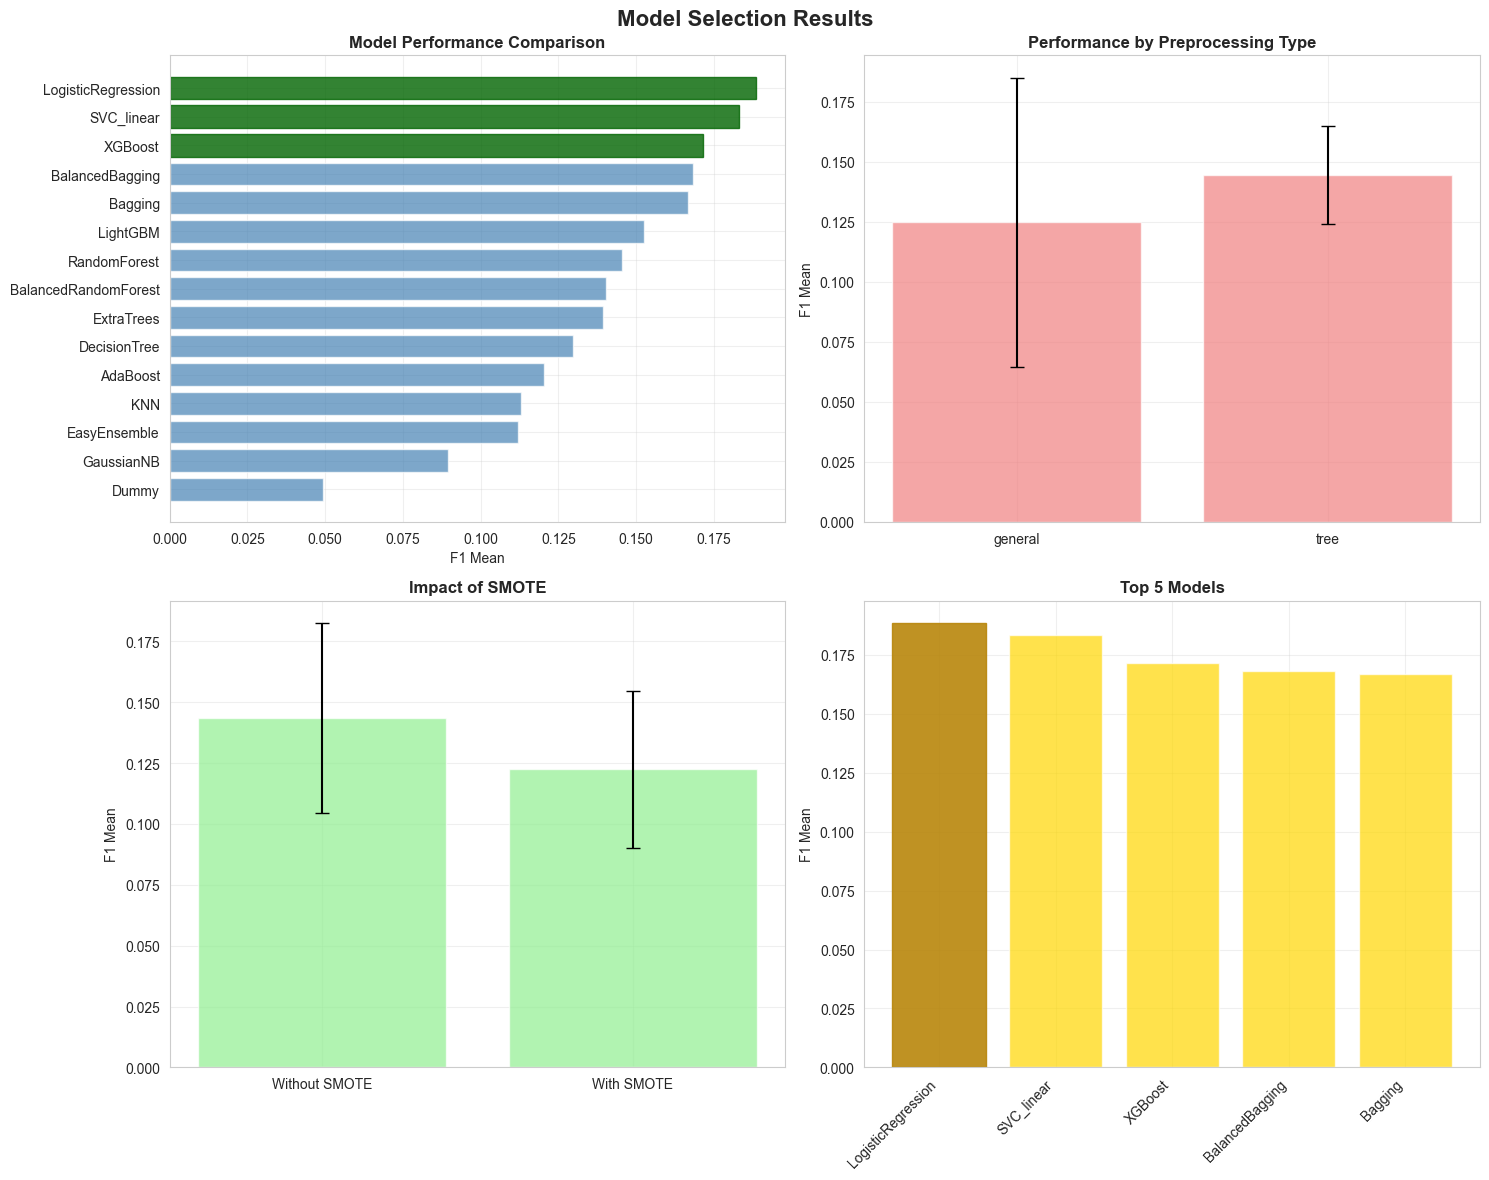

Visualization created successfully

Best model from selection: LogisticRegression with f1_mean: 0.1886
   Preprocessing type: general
   Uses SMOTE: False

Final Result: LogisticRegression selected as best model


In [13]:
# Display results with proper error handling
if not model_results_df.empty:
    try:
        # Sort and display results
        if PRIMARY_METRIC_MODEL_SELECTION in model_results_df.columns:
            sorted_df = model_results_df.sort_values(by=PRIMARY_METRIC_MODEL_SELECTION, ascending=False)
            display(sorted_df)
        else:
            print(f"Warning: Primary metric '{PRIMARY_METRIC_MODEL_SELECTION}' not found in results")
            display(model_results_df)
    except Exception as e:
        print(f"Error displaying results: {e}")
        display(model_results_df.head())
else:
    print("No model results to display.")

# Analyze results with comprehensive validation
best_model_name = None
analysis_summary = {}

if not model_results_df.empty and PRIMARY_METRIC_MODEL_SELECTION in model_results_df.columns:
    # Filter out models with errors or NaN scores
    valid_model_results_df = model_results_df.dropna(subset=[PRIMARY_METRIC_MODEL_SELECTION])
    if 'error' in model_results_df.columns:
        valid_model_results_df = valid_model_results_df[valid_model_results_df['error'].isna()]
    
    if not valid_model_results_df.empty:
        try:
            analysis_summary = analyze_model_results(valid_model_results_df, primary_metric=PRIMARY_METRIC_MODEL_SELECTION)
            
            # Only create visualization if analysis succeeded
            if analysis_summary and 'error' not in analysis_summary:
                create_results_visualization(valid_model_results_df, analysis_summary, primary_metric=PRIMARY_METRIC_MODEL_SELECTION)

                # Extract best model information safely
                if 'best_model' in analysis_summary and analysis_summary['best_model']:
                    best_model_info = analysis_summary['best_model']
                    best_model_name = best_model_info['name']
                    print(f"\nBest model from selection: {best_model_name} with {PRIMARY_METRIC_MODEL_SELECTION}: {best_model_info['score']:.4f}")
                    
                    # Additional model details
                    print(f"   Preprocessing type: {best_model_info.get('preprocessing', 'unknown')}")
                    print(f"   Uses SMOTE: {best_model_info.get('uses_smote', 'unknown')}")
                else:
                    print("\nCould not extract best model information from analysis")
            else:
                print(f"\nAnalysis failed: {analysis_summary.get('error', 'Unknown error')}")
                
        except Exception as e:
            print(f"\nError during analysis: {e}")
            analysis_summary = {'error': str(e)}
    else:
        print(f"\nNo valid models with primary metric '{PRIMARY_METRIC_MODEL_SELECTION}' found after filtering")
        print("This could be due to:")
        print("  - All models failed during cross-validation")
        print("  - Primary metric not calculated properly")
        print("  - Data loading or preprocessing issues")
        
elif not model_results_df.empty:
    print(f"\nPrimary metric '{PRIMARY_METRIC_MODEL_SELECTION}' not found in results columns")
    print(f"Available columns: {list(model_results_df.columns)}")
else:
    print("\nModel selection produced no results")
    print("This indicates a fundamental issue with:")
    print("  - Data loading")
    print("  - Model configuration") 
    print("  - Cross-validation setup")

# Final status summary
if best_model_name:
    print(f"\nFinal Result: {best_model_name} selected as best model")
else:
    print(f"\nNo best model could be determined")
    print("Review the errors above and check:")
    print("  - Data preprocessing artifacts")
    print("  - Model configurations")
    print("  - Cross-validation setup")